In [24]:
! pip install pyreadstat pyarrow matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [25]:
import pandas as pd

Taiwan_QQQ = pd.read_feather('Cleaned_2022_Science.feather')

# 切割資料集為訓練集和測試集
from sklearn.model_selection import train_test_split
X = Taiwan_QQQ.drop(['Science_level'], axis=1)
y = Taiwan_QQQ['Science_level']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

mi = mutual_info_classif(X_train, y_train)
mi_scores = pd.Series(mi, index=X.columns)
mi_scores = mi_scores.sort_values(ascending=False)  # 降序排序
print(mi_scores[:100])

MATHEFF       0.124965
ISCEDP        0.084839
ICTENQ        0.072846
ICTOUT        0.072129
ICTWKDY       0.071335
                ...   
IC183Q04JA    0.019910
IC183Q13JA    0.019538
ST251Q06JA    0.019324
ST326Q05JA    0.019305
IC176Q01JA    0.019236
Length: 100, dtype: float64


In [27]:
selected_column = mi_scores[:100].keys()
X_train = X_train[selected_column]
X_test = X_test[selected_column]

X_train.head()

,MATHEFF,ISCEDP,ICTENQ,ICTOUT,ICTWKDY,MATHEF21,ICTSUBJ,ICTWKEND,ESCS,HOMEPOS,...,ST296Q03JA,ST347Q01JA,IC172Q05JA,IC177Q07JA,ST297Q07JA,IC183Q04JA,IC183Q13JA,ST251Q06JA,ST326Q05JA,IC176Q01JA
116617,-1.5802,244.0,-2.3763,-1.8681,0.6867,-1.5003,-1.0124,1.0960,-1.3958,-1.2849,...,1.0,2.0,2.0,2.0,0.0,1.0,1.0,1.0,4.0,1.0
113200,-0.0701,344.0,0.5375,0.5817,0.0253,1.0780,-0.1212,0.1378,1.1512,0.7375,...,2.0,1.0,2.0,2.0,1.0,4.0,4.0,3.0,5.0,5.0
114431,-0.2596,354.0,-1.3812,-0.6846,-1.1954,0.7073,-1.0124,-1.5204,-1.3682,-1.4658,...,2.0,1.0,3.0,1.0,0.0,4.0,4.0,1.0,9.0,3.0
116880,-3.4814,354.0,-1.3812,-2.5404,0.1499,-2.1867,-2.0101,1.1959,-1.0825,-2.0020,...,1.0,1.0,2.0,4.0,0.0,2.0,2.0,1.0,1.0,1.0
114548,-3.4257,244.0,-1.1017,-2.5404,0.1370,-2.1406,-0.4015,1.9384,-1.5954,-0.3491,...,1.0,6.0,2.0,1.0,0.0,4.0,4.0,1.0,3.0,1.0


In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

svm_pipeline = Pipeline([('scaler', StandardScaler()), ('svm', SVC())])

# 設定參數網格
svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf', 'poly'],
    'svm__gamma': [0.1, 1, 10]
}


# 創建 GridSearchCV 物件
svm_grid_search = GridSearchCV(svm_pipeline, svm_param_grid, cv=5, verbose=4, n_jobs=-1)

# 執行網格搜索
svm_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = svm_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", svm_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(svm_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
best_model = svm_grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(test_score))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'linear'}
Fold 1 score: 0.8271077908217717
Fold 2 score: 0.8110992529348986
Fold 3 score: 0.7790821771611526
Fold 4 score: 0.8175026680896478
Fold 5 score: 0.8025613660618997
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'rbf'}
Fold 1 score: 0.5325506937033084
Fold 2 score: 0.5325506937033084
Fold 3 score: 0.5325506937033084
Fold 4 score: 0.5325506937033084
Fold 5 score: 0.5325506937033084
Params: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'poly'}
Fold 1 score: 0.7716115261472786
Fold 2 score: 0.7865528281750267
Fold 3 score: 0.7609391675560299
Fold 4 score: 0.7908217716115261
Fold 5 score: 0.7865528281750267
Params: {'svm__C': 0.1, 'svm__gamma': 1, 'svm__kernel': 'linear'}
Fold 1 score: 0.8271077908217717
Fold 2 score: 0.8110992529348986
Fold 3 score: 0.7790821771611526
Fold 4 score: 0.8175026680896478
Fold 5 score: 0.8025613660618997
Params: {'svm

In [29]:
from sklearn.ensemble import RandomForestClassifier

# 設定參數網格
rf_param_grid = {
    'n_estimators': [100, 200, 300],  # 決策樹的數量
    'max_depth': [None, 10, 20, 30],  # 最大深度
    'min_samples_split': [2, 5, 10],  # 每個節點至少包含的數據量，才能繼續分割
    'min_samples_leaf': [1, 2, 4]    # 每個葉子最少的樣本數
}

# 創建 GridSearchCV 物件
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=5, verbose=2, n_jobs=-1)

# 執行網格搜索
rf_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = rf_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳參數和模型
print("Best parameters:", rf_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(rf_grid_search.best_score_))

# 使用最佳參數的模型對測試集進行預測
rf_best_model = rf_grid_search.best_estimator_
rf_test_score = rf_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(rf_test_score))

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Fold 1 score: 0.8228388473852721
Fold 2 score: 0.8207043756670224
Fold 3 score: 0.7961579509071505
Fold 4 score: 0.8153681963713981
Fold 5 score: 0.8025613660618997
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Fold 1 score: 0.823906083244397
Fold 2 score: 0.8281750266808965
Fold 3 score: 0.8057630736392742
Fold 4 score: 0.823906083244397
Fold 5 score: 0.8036286019210246
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Fold 1 score: 0.8281750266808965
Fold 2 score: 0.8303094983991463
Fold 3 score: 0.7982924226254002
Fold 4 score: 0.8271077908217717
Fold 5 score: 0.8036286019210246
Params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Fold 1 score: 0.8292422625400213
Fold 2 score: 0.82710779082

In [30]:
import xgboost as xgb

xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
# 设置参数网格
xg_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 2, 3]
}


# 创建 GridSearchCV 对象
xg_grid_search = GridSearchCV(xgb_model, xg_param_grid, cv=5, verbose=4, n_jobs=-1)

# 执行网格搜索
xg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = xg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", xg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(xg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
xgb_best_model = xg_grid_search.best_estimator_
xgb_test_score = xgb_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(xgb_test_score))

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50}
Fold 1 score: 0.7620064034151548
Fold 2 score: 0.7609391675560299
Fold 3 score: 0.759871931696905
Fold 4 score: 0.7566702241195304
Fold 5 score: 0.7353255069370331
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
Fold 1 score: 0.7780149413020278
Fold 2 score: 0.7737459978655283
Fold 3 score: 0.767342582710779
Fold 4 score: 0.7801494130202775
Fold 5 score: 0.7641408751334045
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
Fold 1 score: 0.8025613660618997
Fold 2 score: 0.8036286019210246
Fold 3 score: 0.7865528281750267
Fold 4 score: 0.8046958377801494
Fold 5 score: 0.7844183564567769
Params: {'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 50}
Fold 1 score: 0.7620064034151548
Fold 2 score: 0.767342582710779
Fold 3 score: 

In [31]:
from sklearn.linear_model import LogisticRegression

# 设置参数网格
lg_param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty':  ['l1', 'l2']
}

# 创建 GridSearchCV 对象
lg_grid_search = GridSearchCV(LogisticRegression(solver='saga'), lg_param_grid, cv=5, verbose=2, n_jobs=-1)

# 执行网格搜索
lg_grid_search.fit(X_train, y_train)

# 访问 cv_results_
cv_results = lg_grid_search.cv_results_

# 打印每折的验证结果
for i in range(len(cv_results['params'])):
    print("Params:", cv_results['params'][i])
    for j in range(5):  # 假设 cv=5
        print(f"Fold {j+1} score:", cv_results[f'split{j}_test_score'][i])

# 最佳参数和模型
print("Best parameters:", lg_grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(lg_grid_search.best_score_))

# 使用最佳参数的模型对测试集进行预测
lg_best_model = lg_grid_search.best_estimator_
lg_test_score = lg_best_model.score(X_test, y_test)
print("Test set score: {:.2f}".format(lg_test_score))

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The ma

Params: {'C': 0.01, 'penalty': 'l1'}
Fold 1 score: 0.7908217716115261
Fold 2 score: 0.7982924226254002
Fold 3 score: 0.7662753468516542
Fold 4 score: 0.7513340448239061
Fold 5 score: 0.768409818569904
Params: {'C': 0.01, 'penalty': 'l2'}
Fold 1 score: 0.8025613660618997
Fold 2 score: 0.8046958377801494
Fold 3 score: 0.7662753468516542
Fold 4 score: 0.7641408751334045
Fold 5 score: 0.7801494130202775
Params: {'C': 0.1, 'penalty': 'l1'}
Fold 1 score: 0.8025613660618997
Fold 2 score: 0.8025613660618997
Fold 3 score: 0.7662753468516542
Fold 4 score: 0.7620064034151548
Fold 5 score: 0.7822838847385272
Params: {'C': 0.1, 'penalty': 'l2'}
Fold 1 score: 0.8014941302027748
Fold 2 score: 0.8036286019210246
Fold 3 score: 0.768409818569904
Fold 4 score: 0.7641408751334045
Fold 5 score: 0.7822838847385272
Params: {'C': 1, 'penalty': 'l1'}
Fold 1 score: 0.8025613660618997
Fold 2 score: 0.8036286019210246
Fold 3 score: 0.767342582710779
Fold 4 score: 0.7641408751334045
Fold 5 score: 0.782283884738527

/Users/ponywen/Documents/Project/DataSciFinal/.venv/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [32]:
import shap
import xgboost as xgb
from sklearn.model_selection import KFold
# {'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__n_estimators': 200}
# classifier = xgb.XGBClassifier(n_estimators=200,min_child_weight=3,max_depth=5, learning_rate=0.1)
xgb_best_model.score(X_test, y_test)

0.8361774744027304

In [33]:
explainer = shap.Explainer(xgb_best_model)
shap_values = explainer(X_test)

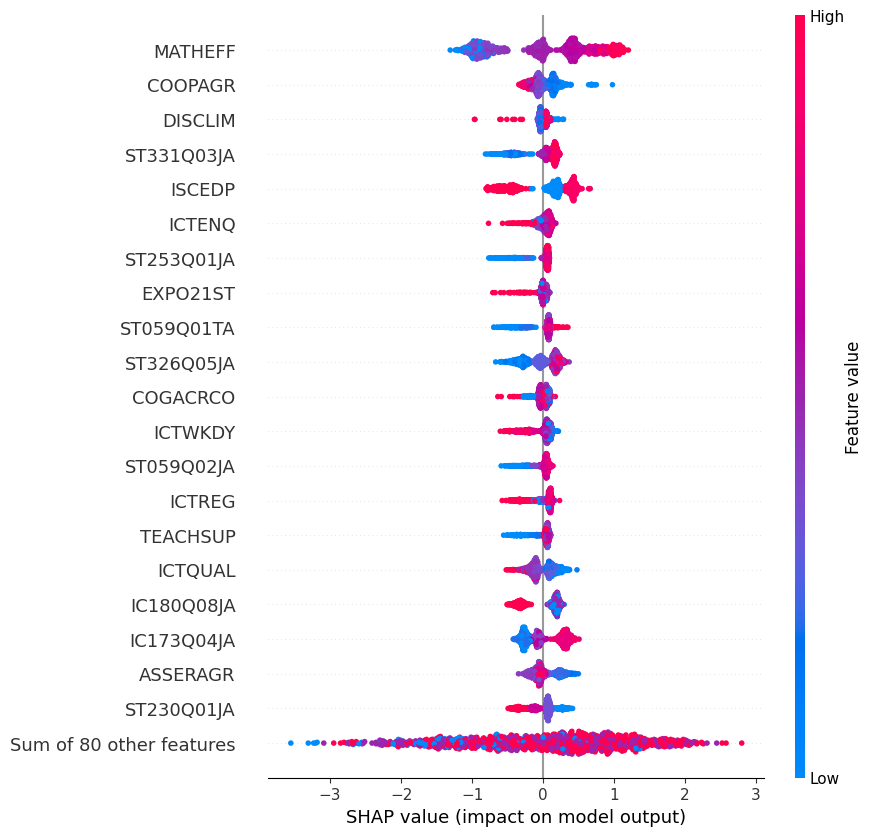

In [37]:
shap.plots.beeswarm(shap_values,max_display=21,order=shap_values.abs.max(0))

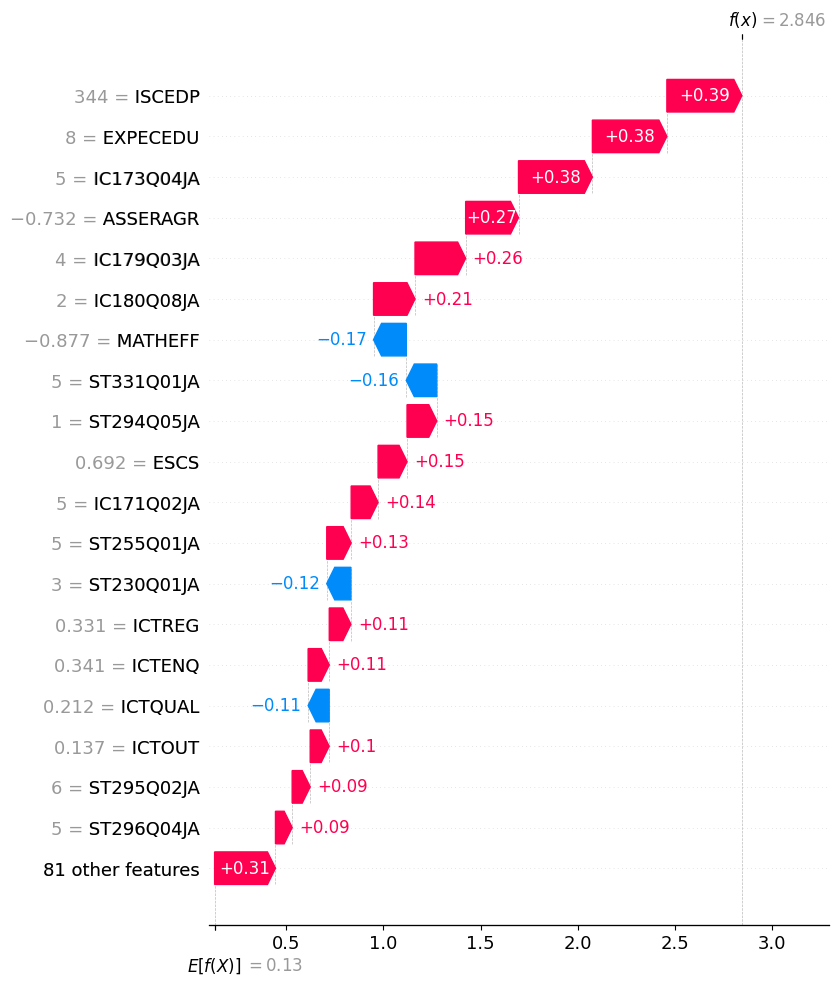

In [35]:
shap.plots.waterfall(shap_values[0], max_display=20)